In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

Fix random seed

In [9]:
import random
# Set the seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set the seed for NumPy
np.random.seed(random_seed)

# Set the seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Loading Dataset

11490434/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


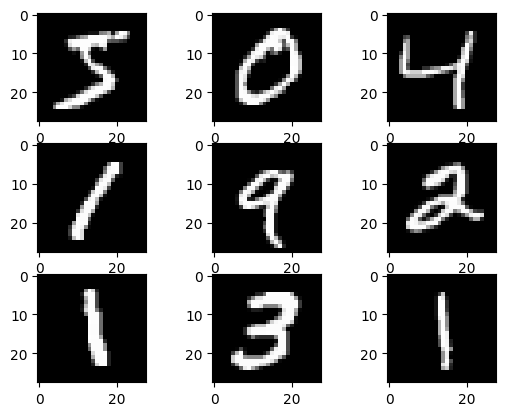

In [10]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print shape
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
 plt.subplot(330 + 1 + i)
 plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.show()

### Preprocessing

In [11]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


### Create a CNN Model

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        #10 numbers
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x) #1 -> 32
        x = F.relu(x)

        x = self.conv2(x) #32 -> 32
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x) #32 -> 64
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [13]:
# Instantiate the model
model = CNN()

# Move the model to a specific device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Display the model summary
summary(model, (1, 28, 28))  # Assuming input size is (1, 28, 28), adjust accordingly


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2           [-1, 32, 20, 20]          25,632
            Conv2d-3             [-1, 64, 6, 6]          51,264
            Linear-4                  [-1, 256]         147,712
            Linear-5                   [-1, 10]           2,570
Total params: 228,010
Trainable params: 228,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.87
Estimated Total Size (MB): 1.13
----------------------------------------------------------------


### Fitting model

In [14]:
def fit(model, optimizer, train_loader):
    # Use GPU to train
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    EPOCHS = 20
    model.train()
    loss_values = []

    for epoch in range(EPOCHS):
        correct = 0
        running_loss = 0.0
        total_samples = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_samples += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = correct / total_samples
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        print('[Epoch %d] Loss: %.3f, Accuracy: %.3f' % (epoch + 1, epoch_loss, accuracy))

    return loss_values


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_adam = CNN().to(device)
Adam = torch.optim.Adam(cnn_adam.parameters(), lr=5e-4, betas=(0.9, 0.999))
Adam_model = fit(cnn_adam, Adam, train_loader)

[Epoch 1] Loss: 0.414, Accuracy: 0.873
[Epoch 2] Loss: 0.150, Accuracy: 0.956
[Epoch 3] Loss: 0.117, Accuracy: 0.966
[Epoch 4] Loss: 0.109, Accuracy: 0.968
[Epoch 5] Loss: 0.095, Accuracy: 0.973
[Epoch 6] Loss: 0.091, Accuracy: 0.974
[Epoch 7] Loss: 0.090, Accuracy: 0.975
[Epoch 8] Loss: 0.086, Accuracy: 0.976
[Epoch 9] Loss: 0.084, Accuracy: 0.976
[Epoch 10] Loss: 0.082, Accuracy: 0.977
[Epoch 11] Loss: 0.082, Accuracy: 0.977
[Epoch 12] Loss: 0.079, Accuracy: 0.978
[Epoch 13] Loss: 0.078, Accuracy: 0.977
[Epoch 14] Loss: 0.076, Accuracy: 0.978
[Epoch 15] Loss: 0.079, Accuracy: 0.978
[Epoch 16] Loss: 0.073, Accuracy: 0.979
[Epoch 17] Loss: 0.075, Accuracy: 0.979
[Epoch 18] Loss: 0.076, Accuracy: 0.979
[Epoch 19] Loss: 0.070, Accuracy: 0.981
[Epoch 20] Loss: 0.071, Accuracy: 0.980


Training SGD

In [16]:
cnn_sgd = CNN().to(device)
SGD_optimizer = torch.optim.SGD(cnn_sgd.parameters(), lr=5e-4)
SGD_model = fit(cnn_sgd, SGD_optimizer, train_loader)

[Epoch 1] Loss: 1.747, Accuracy: 0.396
[Epoch 2] Loss: 0.753, Accuracy: 0.761
[Epoch 3] Loss: 0.465, Accuracy: 0.857
[Epoch 4] Loss: 0.360, Accuracy: 0.889
[Epoch 5] Loss: 0.312, Accuracy: 0.905
[Epoch 6] Loss: 0.272, Accuracy: 0.917
[Epoch 7] Loss: 0.246, Accuracy: 0.925
[Epoch 8] Loss: 0.225, Accuracy: 0.931
[Epoch 9] Loss: 0.208, Accuracy: 0.937
[Epoch 10] Loss: 0.200, Accuracy: 0.939
[Epoch 11] Loss: 0.192, Accuracy: 0.942
[Epoch 12] Loss: 0.184, Accuracy: 0.944
[Epoch 13] Loss: 0.174, Accuracy: 0.947
[Epoch 14] Loss: 0.168, Accuracy: 0.950
[Epoch 15] Loss: 0.162, Accuracy: 0.951
[Epoch 16] Loss: 0.155, Accuracy: 0.954
[Epoch 17] Loss: 0.151, Accuracy: 0.955
[Epoch 18] Loss: 0.143, Accuracy: 0.957
[Epoch 19] Loss: 0.138, Accuracy: 0.958
[Epoch 20] Loss: 0.132, Accuracy: 0.960


Training a couple more popular Alg to compare

Adagrad

In [17]:
cnn_Adagrad = CNN().to(device)
Adagrad = torch.optim.Adagrad(cnn_Adagrad.parameters(), lr=5e-4)
Adagrad_model = fit(cnn_Adagrad, Adagrad, train_loader)

[Epoch 1] Loss: 1.342, Accuracy: 0.553
[Epoch 2] Loss: 0.637, Accuracy: 0.793
[Epoch 3] Loss: 0.490, Accuracy: 0.842
[Epoch 4] Loss: 0.419, Accuracy: 0.868
[Epoch 5] Loss: 0.371, Accuracy: 0.881
[Epoch 6] Loss: 0.336, Accuracy: 0.896
[Epoch 7] Loss: 0.314, Accuracy: 0.902
[Epoch 8] Loss: 0.295, Accuracy: 0.908
[Epoch 9] Loss: 0.278, Accuracy: 0.914
[Epoch 10] Loss: 0.264, Accuracy: 0.918
[Epoch 11] Loss: 0.255, Accuracy: 0.921
[Epoch 12] Loss: 0.242, Accuracy: 0.925
[Epoch 13] Loss: 0.236, Accuracy: 0.927
[Epoch 14] Loss: 0.228, Accuracy: 0.929
[Epoch 15] Loss: 0.223, Accuracy: 0.931
[Epoch 16] Loss: 0.215, Accuracy: 0.933
[Epoch 17] Loss: 0.212, Accuracy: 0.935
[Epoch 18] Loss: 0.205, Accuracy: 0.937
[Epoch 19] Loss: 0.204, Accuracy: 0.938
[Epoch 20] Loss: 0.193, Accuracy: 0.940


RMSprop

In [18]:
cnn_RMSprop = CNN().to(device)
RMSprop = torch.optim.RMSprop(cnn_RMSprop.parameters(), lr=5e-4)
RMSprop_model = fit(cnn_RMSprop, RMSprop, train_loader)

[Epoch 1] Loss: 0.387, Accuracy: 0.888
[Epoch 2] Loss: 0.141, Accuracy: 0.959
[Epoch 3] Loss: 0.117, Accuracy: 0.967
[Epoch 4] Loss: 0.104, Accuracy: 0.971
[Epoch 5] Loss: 0.096, Accuracy: 0.974
[Epoch 6] Loss: 0.094, Accuracy: 0.974
[Epoch 7] Loss: 0.093, Accuracy: 0.975
[Epoch 8] Loss: 0.088, Accuracy: 0.976
[Epoch 9] Loss: 0.086, Accuracy: 0.976
[Epoch 10] Loss: 0.091, Accuracy: 0.976
[Epoch 11] Loss: 0.090, Accuracy: 0.976
[Epoch 12] Loss: 0.086, Accuracy: 0.977
[Epoch 13] Loss: 0.088, Accuracy: 0.977
[Epoch 14] Loss: 0.090, Accuracy: 0.976
[Epoch 15] Loss: 0.090, Accuracy: 0.976
[Epoch 16] Loss: 0.092, Accuracy: 0.977
[Epoch 17] Loss: 0.092, Accuracy: 0.977
[Epoch 18] Loss: 0.092, Accuracy: 0.977
[Epoch 19] Loss: 0.091, Accuracy: 0.977
[Epoch 20] Loss: 0.092, Accuracy: 0.977


L-BFGS (Approximate Hessian)  \
will not converge as expect (BFGS does not scale well on large dataset)

In [ ]:
cnn_LBFGS = CNN().to(device)
LBFGS = torch.optim.LBFGS(cnn_LBFGS.parameters(), history_size=20, max_iter=4, lr=0.01)

criterion = nn.CrossEntropyLoss()
epochs = 30
LBFGS_loss = []

for epoch in range(epochs):
    running_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      def closure():
        # Zero gradients
        LBFGS.zero_grad()
        y_pred = cnn_LBFGS(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        return loss

      LBFGS.step(closure)
      loss = closure()
      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    LBFGS_loss.append(epoch_loss)

    print('[Epoch %d] Loss: %.3f' % (epoch + 1, epoch_loss))

Plot Training Loss

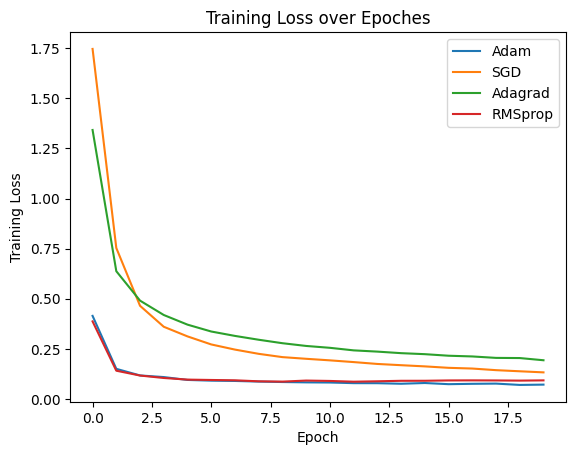

In [19]:
plt.plot(Adam_model, label='Adam')
plt.plot(SGD_model,label='SGD')
plt.plot(Adagrad_model,label='Adagrad')
plt.plot(RMSprop_model,label='RMSprop')
#plt.plot(LBFGS_loss,label='L-BFGS')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epoches')
plt.legend()
plt.show()

In [20]:
def evaluate(model):
  model.eval()
  correct = 0

  with torch.no_grad():
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        #calculate accuracy
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()

    accuracy = correct / (len(test_loader.dataset))
    print("Accuracy: {:.3f}%".format(accuracy * 100))


In [21]:
evaluate(cnn_adam)


Accuracy: 99.320%


In [22]:
evaluate(cnn_sgd)

Accuracy: 98.420%


In [23]:
evaluate(cnn_RMSprop)

Accuracy: 99.040%


In [24]:
evaluate(cnn_Adagrad)

Accuracy: 97.810%
